# Extracting ellipse parmeters from rings

During a powder diffraction experiment, the scattering occures along cconcentric cones, originating from the sample position and named after 2 famous scientists: Debye and Scherrer. 

![Debye-Scherrer rings](Debye-Scherrer_rings.png)

Those cones are intersected by the detector and all the calibration step in pyFAI comes down is fitting the "ring" seen on the detector into a meaningful experimental geometry.

In the most common case, a flat detector is mounted orthogonal to the incident beam and all pixel have the same size. 
The diffraction patern is then a set of concentric cercles.
When the detector is still flat and all the pixels are the same but the mounting may be a bit *off*, or maybe for other technical reason one gets a set of concentric ellipses. 
This procedures explains how to extract the center coordinates, axis lengths and orientation. 

The code in pyFAI is heavily inspired from:
https://github.com/ndvanforeest/fit_ellipse
It uses a SVD decomposition in a similar way to the Wolfgang Kabsch's algorithm (1976) to retrieve the best ellipse fitting all point without actually performing a fit.


In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot
from pyFAI.utils.ellipse import fit_ellipse
import inspect
print(inspect.getsource(fit_ellipse))

def fit_ellipse(pty, ptx, _allow_delta=True):
    """Fit an ellipse

    inspired from
    http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html

    :param pty: point coordinates in the slow dimension (y)
    :param ptx: point coordinates in the fast dimension (x)
    :raise ValueError: If the ellipse can't be fitted
    """
    x = ptx[:, numpy.newaxis]
    y = pty[:, numpy.newaxis]
    D = numpy.hstack((x * x, x * y, y * y, x, y, numpy.ones_like(x)))
    S = numpy.dot(D.T, D)
    try:
        inv = numpy.linalg.inv(S)
    except numpy.linalg.LinAlgError:
        if not _allow_delta:
            raise ValueError("Ellipse can't be fitted")
        # Try to do the same with a delta
        delta = 100
        ellipse = fit_ellipse(pty + delta, ptx + delta, _allow_delta=False)
        y0, x0, angle, wlong, wshort = ellipse
        return Ellipse(y0 - delta, x0 - delta, angle, wlong, wshort)

    C = numpy.zeros([6, 6])
    C[0, 2] = C[2, 0] = 2
    C[1, 1] = -1
    E, V = numpy.li

In [3]:
from matplotlib import patches
from numpy import rad2deg

def display(ptx, pty, ellipse=None):
    """A function to overlay a set of points and the calculated ellipse
    """
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    if ellipse is not None:
        error = False
        y0, x0, angle, wlong, wshort = ellipse
        if wshort == 0:
            error = True
            wshort = 0.0001
        if wlong == 0:
            error = True
            wlong = 0.0001
        patch = patches.Arc((x0, y0), width=wlong*2, height=wshort*2, angle=rad2deg(angle))
        if error:
            patch.set_color("red")
        else:
            patch.set_color("green")
        ax.add_patch(patch)

        bbox = patch.get_window_extent()
        ylim = min(y0 - wlong, pty.min()), max(y0 + wlong, pty.max())
        xlim = min(x0 - wlong, ptx.min()), max(x0 - wlong, ptx.max())
    else:
        ylim = pty.min(), pty.max()
        xlim = ptx.min(), ptx.max()
    ax.plot(ptx, pty, "ro", color="blue")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    pyplot.show()

Ellipse(center_1=1.2553662584011611, center_2=2.168550930860949, angle=-0.11808333491078393, half_long_axis=1.3406710120962717, half_short_axis=0.7364617231819363)


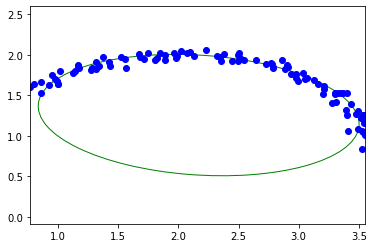

In [4]:
from numpy import sin, cos, random, pi, linspace
arc = 0.8
npt = 100
R = linspace(0, arc * pi, npt)
ptx = 1.5 * cos(R) + 2 + random.normal(scale=0.05, size=npt)
pty = sin(R) + 1. + random.normal(scale=0.05, size=npt)

ellipse = fit_ellipse(pty, ptx)
print(ellipse)
display(ptx, pty, ellipse)

Ellipse(center_1=10.000000000021668, center_2=10.00000000001636, angle=2.501627558643098, half_long_axis=19.99999999998908, half_short_axis=19.999999999972612)


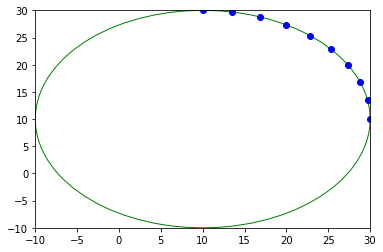

In [5]:
angles = linspace(0, pi / 2, 10)
pty = sin(angles) * 20 + 10
ptx = cos(angles) * 20 + 10
ellipse = fit_ellipse(pty, ptx)
print(ellipse)
display(ptx, pty, ellipse)

Ellipse(center_1=49.99999999999963, center_2=100.00000000000023, angle=3.204103649068202e-13, half_long_axis=19.99999999998351, half_short_axis=10.000000000008267)


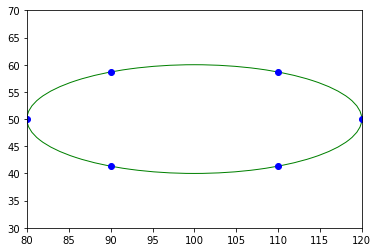

In [6]:
angles = linspace(0, pi * 2, 6, endpoint=False)
pty = sin(angles) * 10 + 50
ptx = cos(angles) * 20 + 100
ellipse = fit_ellipse(pty, ptx)
print(ellipse)
display(ptx, pty, ellipse)

Ellipse(center_1=-9.276530161312418e-16, center_2=-1.32634644008552e-15, angle=1.5707963267948966, half_long_axis=19.999999999999996, half_short_axis=9.999999999999998)


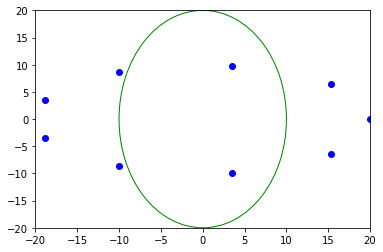

In [7]:
# Center to zero
angles = linspace(0, 2*pi, 9, endpoint=False)
pty = sin(angles+0) * 10 + 0
ptx = cos(angles+0) * 20 + 0
ellipse = fit_ellipse(pty, ptx)
print(ellipse)
display(ptx, pty, ellipse)

Ellipse(center_1=50.00000000000087, center_2=100.00000000000139, angle=0.5535743588957454, half_long_axis=18.090169943676262, half_short_axis=6.909830056278465)


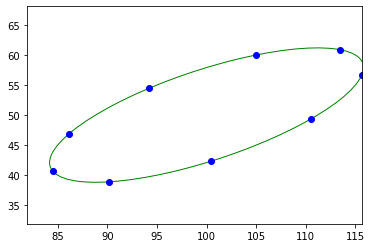

In [8]:
angles = linspace(0, 2 * pi, 9, endpoint=False)
pty = 50 + 10 * cos(angles) + 5 * sin(angles)
ptx = 100 + 5 * cos(angles) + 15 * sin(angles)
ellipse = fit_ellipse(pty, ptx)
print(ellipse)
display(ptx, pty, ellipse)

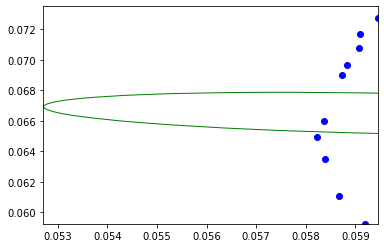

In [9]:
# Points from real peaking
from numpy import array
pty = array([0.06599215, 0.06105629, 0.06963708, 0.06900191, 0.06496001, 0.06352082, 0.05923421, 0.07080027, 0.07276284, 0.07170048])
ptx = array([0.05836343, 0.05866434, 0.05883284, 0.05872581, 0.05823667, 0.05839846, 0.0591999, 0.05907079, 0.05945377, 0.05909428])
try:
    ellipse = fit_ellipse(pty, ptx)
except Exception as e:
    ellipse = None
    print(e)
display(ptx, pty, ellipse)

Ellipse can't be fitted


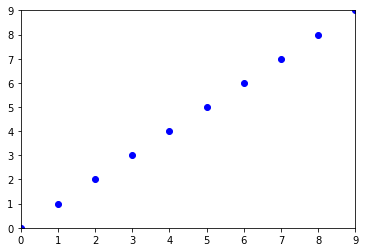

In [10]:
# Line
from numpy import arange
pty = arange(10)
ptx = arange(10)
try:
    ellipse = fit_ellipse(pty, ptx)
except Exception as e:
    ellipse = None
    print(e)
display(ptx, pty, ellipse)

## Conclusion
Within pyFAI's calibration process, the parameters of the ellipse are used in first instance as input guess for starting the fit procedure, which uses *slsqp* from scipy.optimize.